## Лабораторна робота 6. **Unsupervised Learning**

Оцінювання даної роботи буде ураховувати якість Ваших висновків та візуалізацій. При наявності ЛИШЕ коду та візуалізацій без роз'яснень, робота оцінюватися НЕ БУДЕ.  

Більшість поставлених в цій лабораторній роботі задач в майбутньому буде ставитись Вами самойстійно!

Під час виконання Вам дозволено користуватися будь-якими зручними для вас бібліотеками для візуалізації. 

Оформлення коментарів повинно проводитися в текстових комірках ноутбука з використанням синтаксису [LaTeX](https://en.wikibooks.org/wiki/LaTeX/Basics) для оформлення тексту та формул. 

Роботи ідентифіковані як ІДЕНТИЧНІ одразу отримують 0 балів.

## Кластерування  

В цій лабораторній роботі Ви будете вирішувати задачу класифікації БЕЗ вчителя. 

In [1]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline 

import os
import warnings


warnings.filterwarnings('ignore')

**Завдання 0** 

Для початку необхідно завантажити вибірку `Mall_Customers` і перейменувати атрибути `Annual Income (k$)` в `Income`,`Spending Score (1-100)` в `SpendingScore`

In [2]:
customer_set = pd.read_csv('mall_Customers.csv')
customer_set = customer_set.rename(columns={'Annual Income (k$)': 'Income', 'Spending Score (1-100)': 'SpendingScore'})

**Завдання 1** 

Підготовка даних до опрацювання

* подивитись які атрибути містить вибірка; 
* вивести розмірність датасету;
* вивести основну статистичну інформацію по числовим змінним;  
* перевірити на наявність `NaN`.   

In [3]:
display(customer_set.head())

,CustomerID,Gender,Age,Income,SpendingScore
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
display("Shape",customer_set.shape)

'Shape'

(200, 5)

In [19]:
display(customer_set.describe())

,Age,Income,SpendingScore
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [20]:
display(customer_set.isnull().sum())

Gender           0
Age              0
Income           0
SpendingScore    0
dtype: int64

## EDA Mall Customers

**Завдання 2** 

Як Ви могли помітити по статистичній аналітиці вибірки вона містить змінну `CustomerID`. Ця змінна не впливає на аналіз даних тому її можна видалити.

In [5]:
customer_set = customer_set.drop('CustomerID', axis=1)

**Завдання 3** 

Побудувати діаграми розподілу по змінним `Age` , `Income` та `SpendingScore`

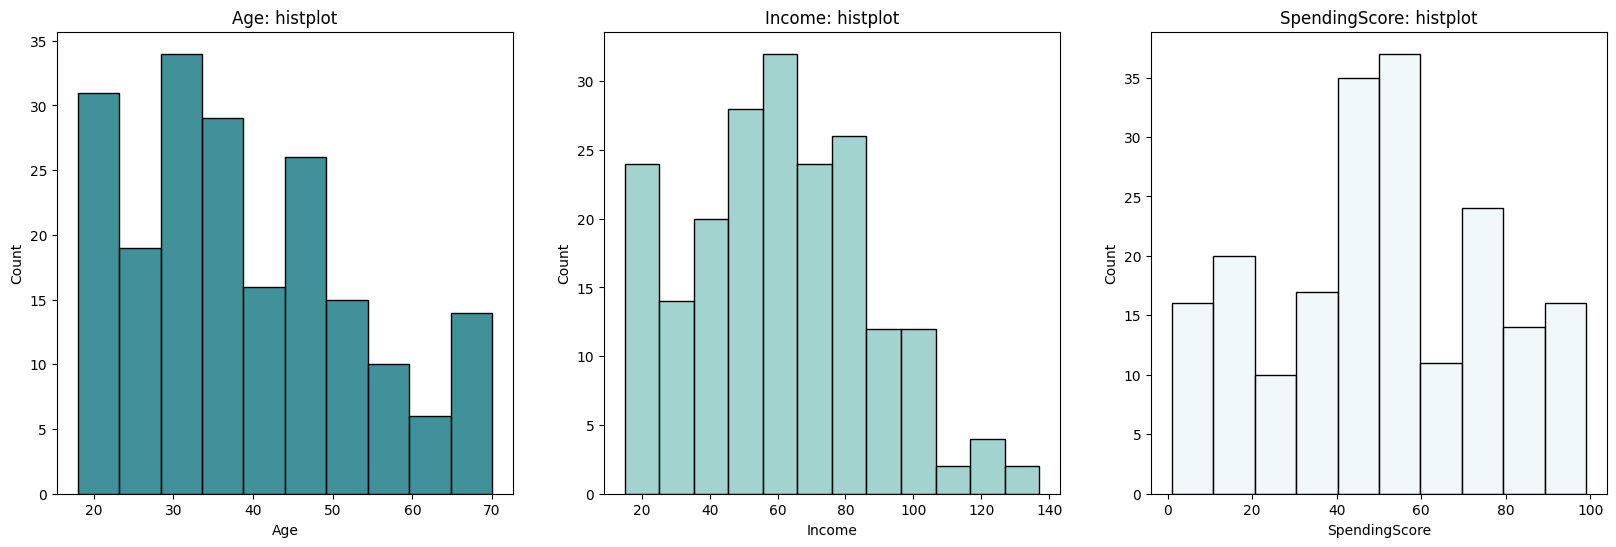

In [6]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(20, 6))

sns.histplot(data=customer_set, x="Age", ax=ax1, color="#006d77", bins=10)
ax1.set_title("Age: histplot")

sns.histplot(data=customer_set, x="Income", ax=ax2, color="#83c5be", bins=12)
ax2.set_title("Income: histplot")

sns.histplot(data=customer_set, x="SpendingScore", ax=ax3, color="#edf6f9", bins=10)
ax3.set_title("SpendingScore: histplot")

plt.show()

**Завдання 4** 

Давайте подивимось на ці змінні `Age` , `Income` та `SpendingScore` відносно змінної `Gender`. 
* Побудуємо `pairplot` по всім змінним відностно змінної `Gender`:  
 
* Побудуємо `pairplot` використовуючи `sns.PairGrid` із заданими `(scatterplot)`, `(kdeplot)` та `(kdeplot, lw=1)` по відповідно правому верхньому куту, діагоналі і лівому нижньому кутут відносно змінної `Gender`:  
 

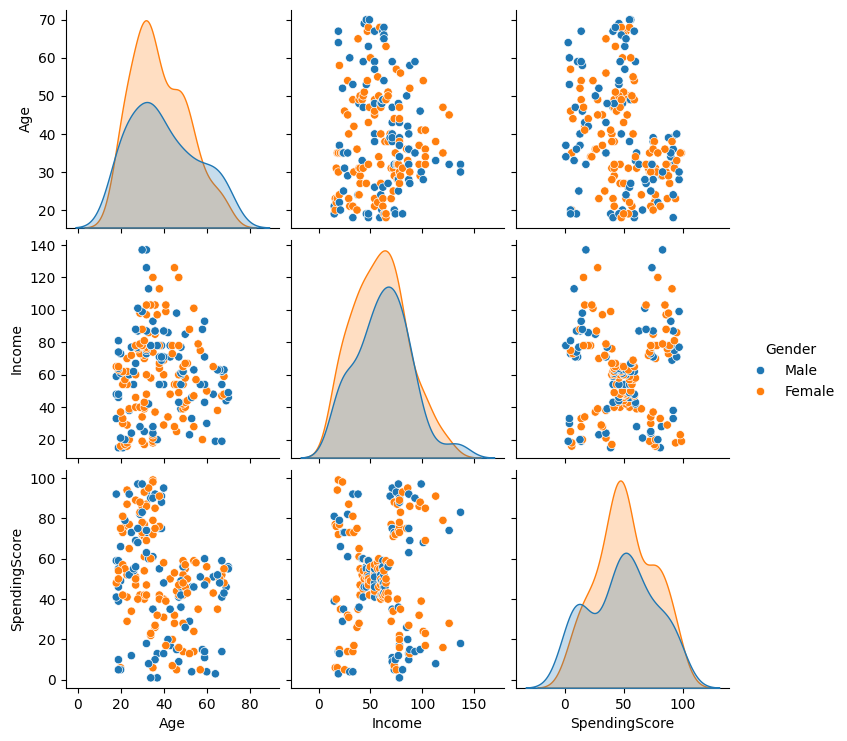

In [7]:
sns.pairplot(customer_set, hue='Gender',  diag_kind='kde', kind='scatter')
plt.show()

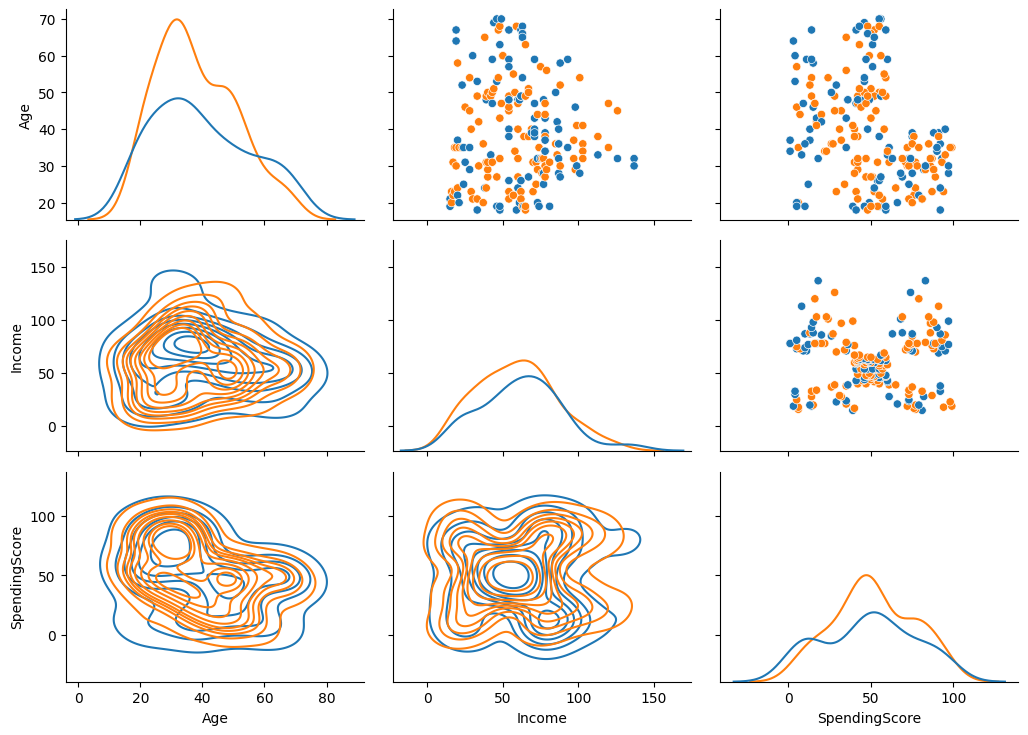

In [8]:
customer_pairgrid = sns.PairGrid(customer_set, hue="Gender", aspect=1.4)
customer_pairgrid.map_upper(sns.scatterplot)
customer_pairgrid.map_diag(sns.kdeplot)
customer_pairgrid.map_lower(sns.kdeplot, lw=1)

plt.show()

**Висновки з 1-4 завдання (детальні)**

1.   Ми подивилися які атрибути містить вибірка, вивели розмірність датасету(200, 5), перевірили на наявність пропущених значень (відсутні) та вивели основну статистичну інформацію по числовим змінним.

2.   По графікам ми можемо бачити що більшість людей мають вік від 20 до 40 років. Прибуток у людей приблизно 50-70 тисяч. Досить мала кількість людей заробляє більше 80 тисяч. Найбільший показник витрат 40-60 тисяч.

3.   В кластеризації ми будемо використовувати спочатку 3 або 5 кластерів. 3 основні групи - Age, SpendingScore i Income. Або 5 тому що За змінними SpendingScore i Income ми можемо побачити формування 5 чітких кластерів. В подальшому ми будемо бачити яка кількість кластерів буде краща.

**Завдання 5** 

Проаналізувати змінну `Gender`:
* вивести співвідношення по статям;
* побудувати `countplot` по `Gender`;  
* побудувати `pie`по `Gender'.  

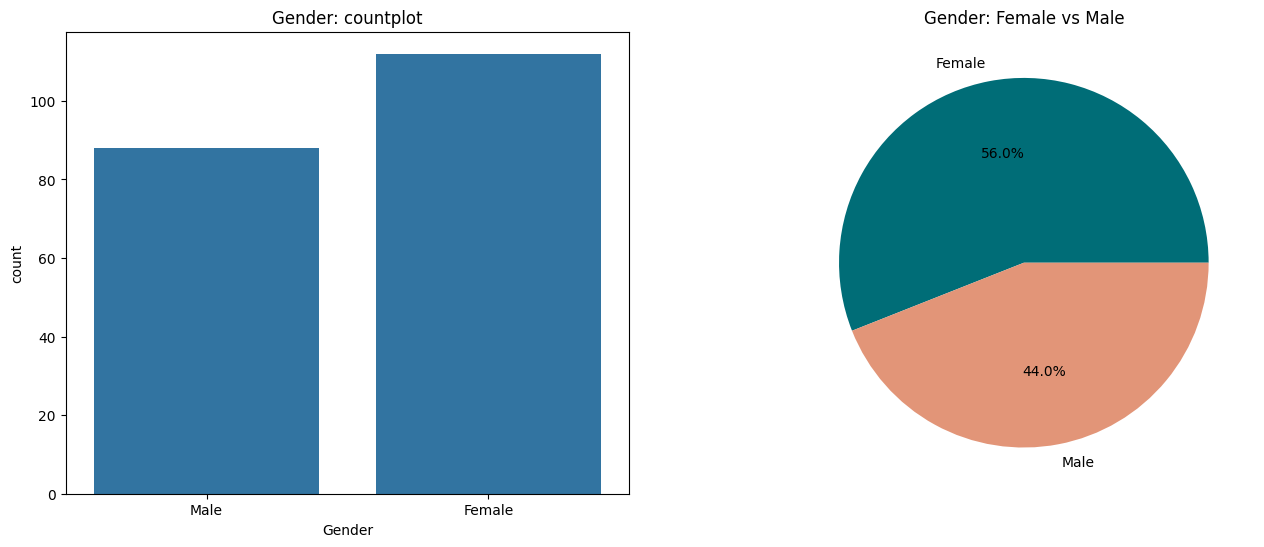

In [9]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(16, 6))
gender_stats = (customer_set["Gender"].value_counts() / customer_set["Gender"].value_counts().sum()) * 100

sns.countplot(customer_set, x="Gender", ax=ax1)
ax1.set_title("Gender: countplot")

ax2.pie(gender_stats, labels=["Female", "Male"], autopct='%1.1f%%', colors=['#006d77', '#e29578'])
ax2.set_title("Gender: Female vs Male")

plt.show()

**Завдання 6** 

Побудувати гістограми [histplot](https://seaborn.pydata.org/generated/seaborn.histplot.html) змінних `Age` та `Income` відносно змінної `Gender` з різними параметрами:
*  подивитись на скільки змінюється візуалізація при різних значеннях параметра `multiple`, наприклад `dodge` та `layer`.

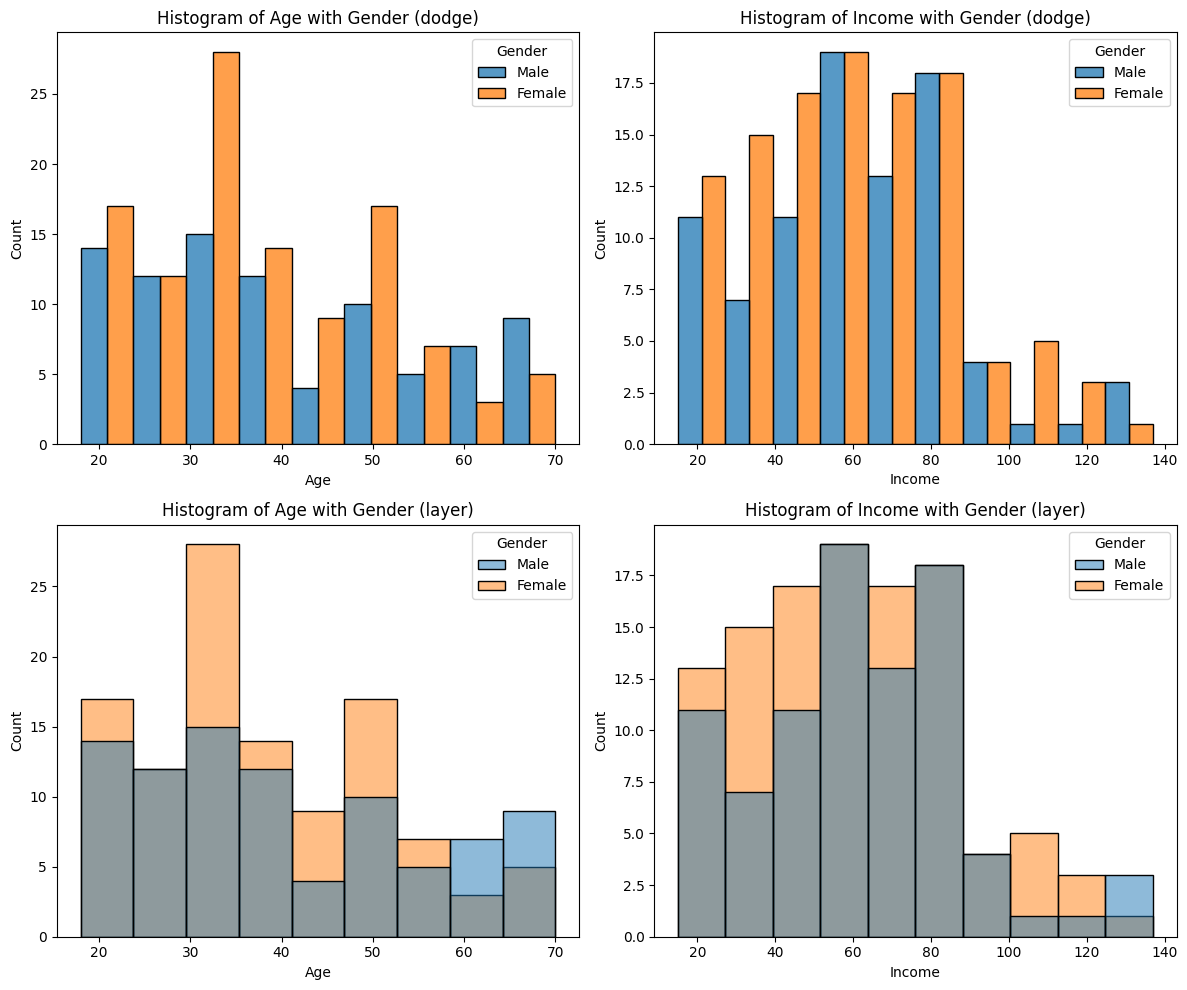

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

sns.histplot(data=customer_set, x="Age", hue="Gender", multiple="dodge", ax=axs[0, 0])
axs[0, 0].set_title('Histogram of Age with Gender (dodge)')

sns.histplot(data=customer_set, x="Income", hue="Gender", multiple="dodge", ax=axs[0, 1])
axs[0, 1].set_title('Histogram of Income with Gender (dodge)')

sns.histplot(data=customer_set, x="Age", hue="Gender", multiple="layer", ax=axs[1, 0])
axs[1, 0].set_title('Histogram of Age with Gender (layer)')

sns.histplot(data=customer_set, x="Income", hue="Gender", multiple="layer", ax=axs[1, 1])
axs[1, 1].set_title('Histogram of Income with Gender (layer)')

plt.tight_layout()
plt.show()

**Завдання 7** 

Побудувати гістограми [histplot](https://seaborn.pydata.org/generated/seaborn.histplot.html) змінної `SpendingScore` відносно змінної `Gender` з різними параметрами:  
* подивитись на скільки змінюється візуалізація при різних значеннях параметра `multiple`, наприклад `dodge` та `layer`. 



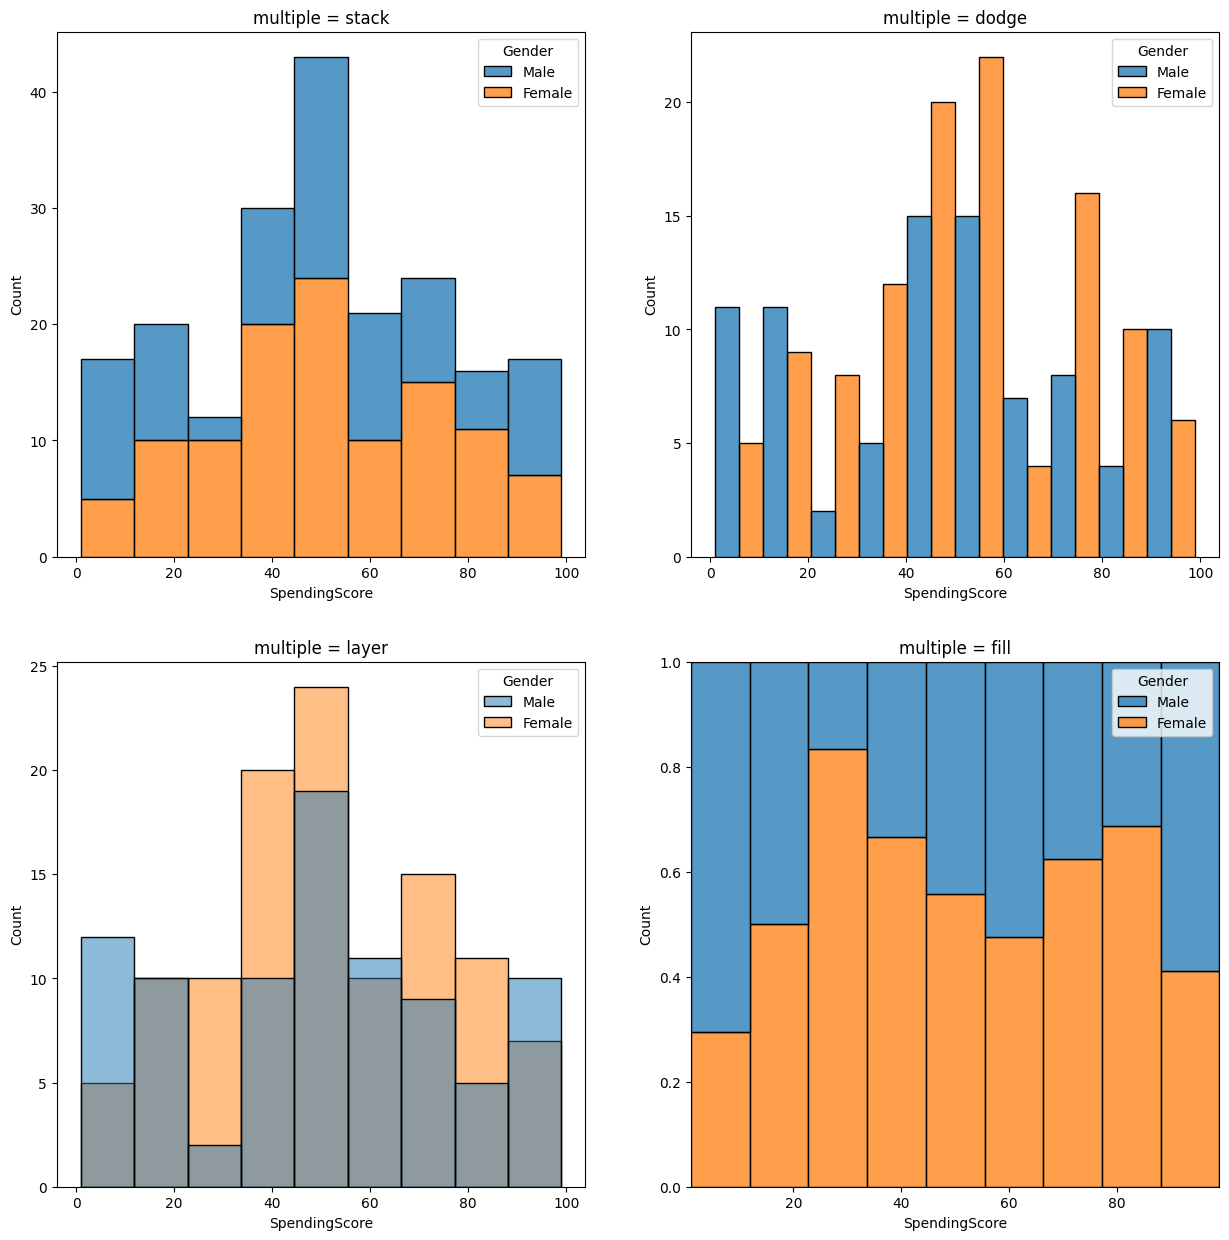

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

sns.histplot(data=customer_set, x="SpendingScore", hue="Gender", ax=ax1, multiple="stack")
ax1.set_title("multiple = stack")

sns.histplot(data=customer_set, x="SpendingScore", hue="Gender", ax=ax2, multiple="dodge", bins=10)
ax2.set_title("multiple = dodge")

sns.histplot(data=customer_set, x="SpendingScore", hue="Gender", ax=ax3, multiple="layer")
ax3.set_title("multiple = layer")

sns.histplot(data=customer_set, x="SpendingScore", hue="Gender", ax=ax4, multiple="fill")
ax4.set_title("multiple = fill")

plt.show()

**Завдання 8** 

Побудувати `boxplot` по змінній `SpendingScore` і подивитись як відрізняються витрати відностно змінної `Gender`. 

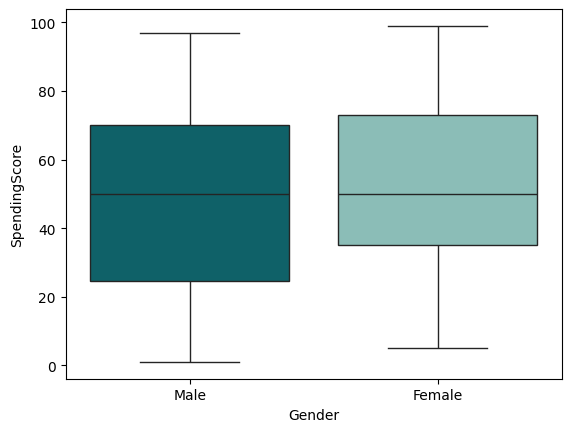

In [12]:
sns.boxplot(data=customer_set, x='Gender',  palette=['#006d77', '#83c5be'], y='SpendingScore' )
plt.show()

**Висновки з завдання 5 - 8(детальні)**

1.  Яке співвідношення груп чоловіків та жінок?

За графіками можна побачити що жінок більше за чоловіків на 12%.

2.  Подивитись які можна виділити групи і як розподілені витрати відностно статі людини? 

Ми можемо виділити настіпні групи по віку:
20-30 - більше витрачають жінки
30-40 - більше жінки
40-50 - більше жінки
50-60 - більше жінки
60-70 - більше чоловіки

3. Чи є різниця між витратами у чоловіків та жінок?

Так, по графікам ми можемо бачити, що жінки витрачають більше ніж чоловіки.


## K-means Method ##

**Завдання 9** 

Як Ви могли помітити, вибірка, з якою ми працюємо, не містить ключової зміної з вірними мітками. Тому перед початком кластерування необхідно визначити (підібрати) оптимальну кількість кластерів на яке буде проведено розбиття. Для цього необхідно:
1. видалити змінну `Gender`, тому що ... **Чому?**;  
2. задати мінімальну та максимальну кількість кластерів самостійно;  
3. На прикладі алгоритму [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), для ознайомлення з тим як працювати в умовах коли кількість кластерів невідома заздалегіть і немає вірних міток з позначками до якого кластеру відноситься спостереження пропонується використати метод [Elbow](https://coderoad.ru/19197715/Scikit-Learn-K-Means-Elbow-criterion) (додаткові джерела: [article_1](https://medium.com/analytics-vidhya/elbow-method-of-k-means-clustering-algorithm-a0c916adc540#:~:text=K%2Dmeans%20clustering%20is%20an,cluster%20with%20the%20nearest%20centroid.), [article_2](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/))

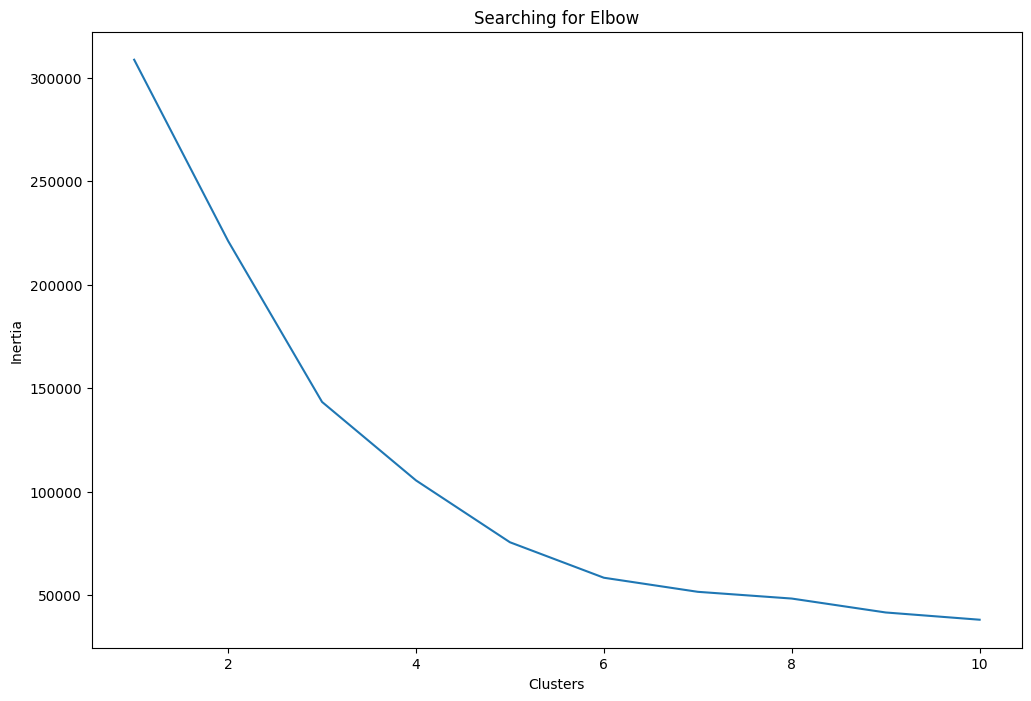

In [23]:
X = customer_set.drop(['Gender'], axis=1)
clusters = []

for i in range(1, 11):
    km = KMeans(n_clusters=i).fit(X)
    clusters.append(km.inertia_)
    
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(1, 11)), y=clusters, ax=ax)
ax.set_title('Searching for Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')

plt.show()

**Висновки з завдання 9 (детальні)** 

1.  Ми задали проміжок кластеризації від 1 до 10. Найбільш чіткими ліктями є 3, 5 та 6 кластери. Враховуючи графіки які ми зробили до цього, то найкраще було б використовувати якраз 3 або 5 кластерів.

2.  Ми видалили атрибут Gender, тому що ми вже знайшли залежності між іншими атрибутами. Використовувати атрибут гендеру буде не дуже прикольно, так як залежності між чоловіками та жінками у нас немає.

**Завдання 10** 

Зробити двовимірну візуалізацію кластеризації методу К-середніх на вибраних Вами двох різних кількостях кластерів використовуючи змінні `Income` та `SpendingScore`. 

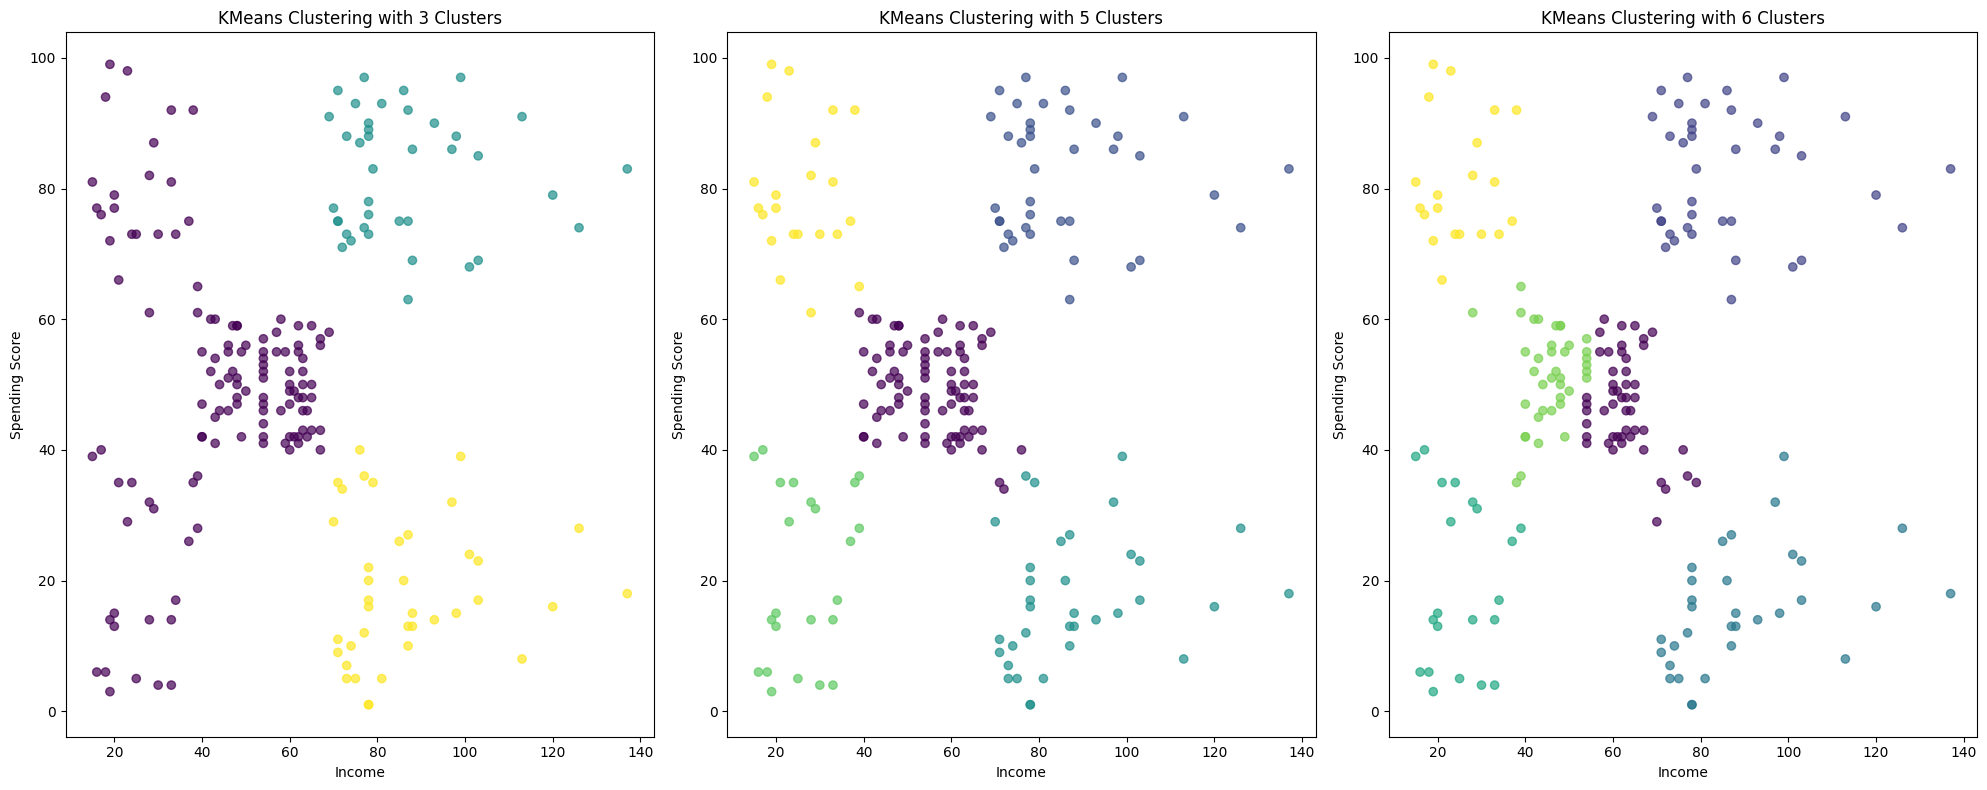

In [14]:
n_clusters_list = [3, 5, 6]

fig, axes = plt.subplots(1, len(n_clusters_list), figsize=(20, 8))

for i, n_clusters in enumerate(n_clusters_list):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(customer_set[['Income', 'SpendingScore']])
    cluster_labels = kmeans.labels_
    axes[i].scatter(customer_set['Income'], customer_set['SpendingScore'], c=cluster_labels, cmap='viridis', alpha=0.7)
    axes[i].set_xlabel('Income')
    axes[i].set_ylabel('Spending Score')
    axes[i].set_title(f'KMeans Clustering with {n_clusters} Clusters')

plt.tight_layout()
plt.show()


**Завдання 11** 

Зробити візуалізацію кластеризації методу К-середніх на вибраних Вами двох різних кількостях кластерів використовуючи [scatter_3d](https://plotly.com/python/3d-scatter-plots/).

In [15]:
X = customer_set[['Income', 'Age', 'SpendingScore']]

n_clusters_1 = 3
kmeans_1 = KMeans(n_clusters=n_clusters_1, random_state=0).fit(X)

n_clusters_2 = 5
kmeans_2 = KMeans(n_clusters=n_clusters_2, random_state=0).fit(X)

fig = px.scatter_3d(X, x=X['Income'], y=X['Age'], z=X['SpendingScore'], color=kmeans_1.labels_)
fig.update_layout(title='KMeans Clustering with 3 Clusters',  width=600, height=400)
fig.show()

fig = px.scatter_3d(X, x=X['Income'], y=X['Age'], z=X['SpendingScore'], color=kmeans_2.labels_)
fig.update_layout(title='KMeans Clustering with 5 Clusters',  width=600, height=400)
fig.show()

**Висновки з завдання 10 - 11 (детальні)** 

1. Визначитась з отриманих візуалізацій яка кількість кластерів є оптимальною на Вашу думку і провести аналіз кластерів, що Ви отримали.

На 2-д та 3-д графіках ми можемо бачити чітко сформовані 5 кластерів. На мою думку очевидно, що 3 кластера буде замало.


## Agglomerative clustering ##

Розглянемо ще один підхід до кластеризації - [агломеративну ієрархічну кластеризацію](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

**Завдання 12** 

Кластеризуйте датасет за допомогою [агломеративної ієрархічнуої кластеризації](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

Мінімально необхідні параметри, що треба налаштувати:  
* `n_clusters`: параметр, який відповідає за кільксіть кластерів на яку буде проведено розбиття вибірки;  
* `linkage`: параметр зв’язку. Цей параметр визначає, яку відстань використовувати між наборами спостережень.
* перевірте як працює цей метод з різними параметрами `linkage`  
* після кожної зміни параметрів - візуалізувати розбиття на кластери

Розрахувати матрицю відстаней для нашого набору даних:
* за допомогою методу [hierarchy.linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) і матриці відстаней кластеризувати дані з різними значеннями параметра `method`
* за допомогою методу [hierarchy.dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html) візуалізувати отримані результати кластеризації у вигляді дендрограм


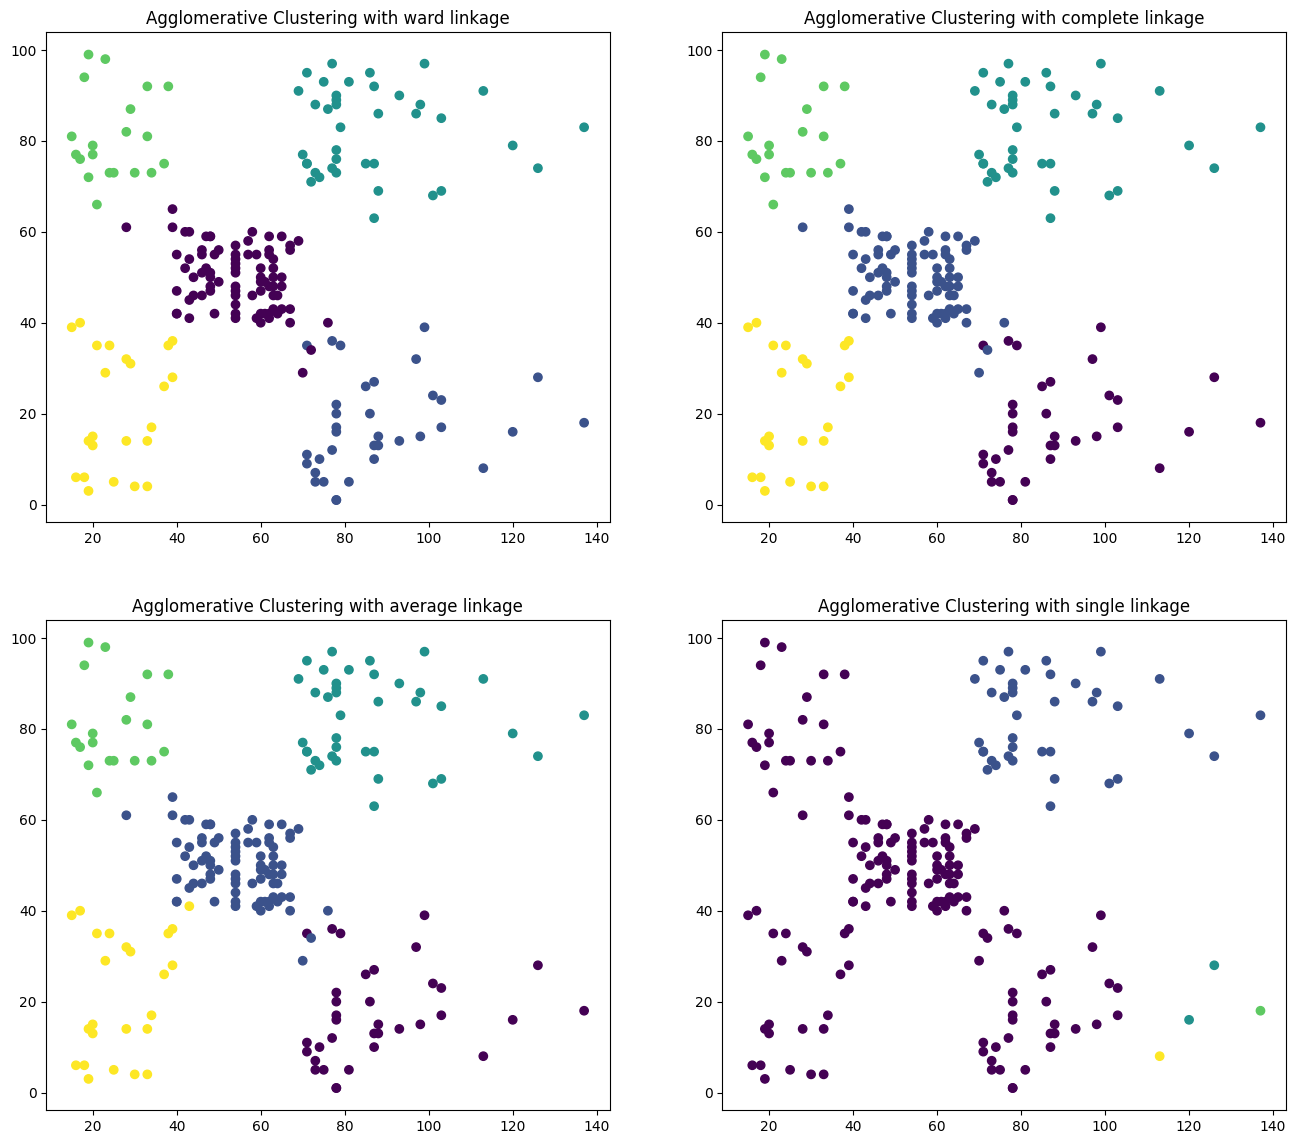

In [16]:
linkages = ['ward', 'complete', 'average', 'single']
fig, axs = plt.subplots(2, 2, figsize=(16, 14))

for i, linkage in enumerate(linkages):
    clustering = AgglomerativeClustering(n_clusters=5, linkage=linkage).fit(X)
    

    ax = axs[i//2, i%2]
    ax.scatter(X['Income'], X['SpendingScore'], c=clustering.labels_, cmap='viridis')
    ax.set_title(f'Agglomerative Clustering with {linkage} linkage')
plt.show()

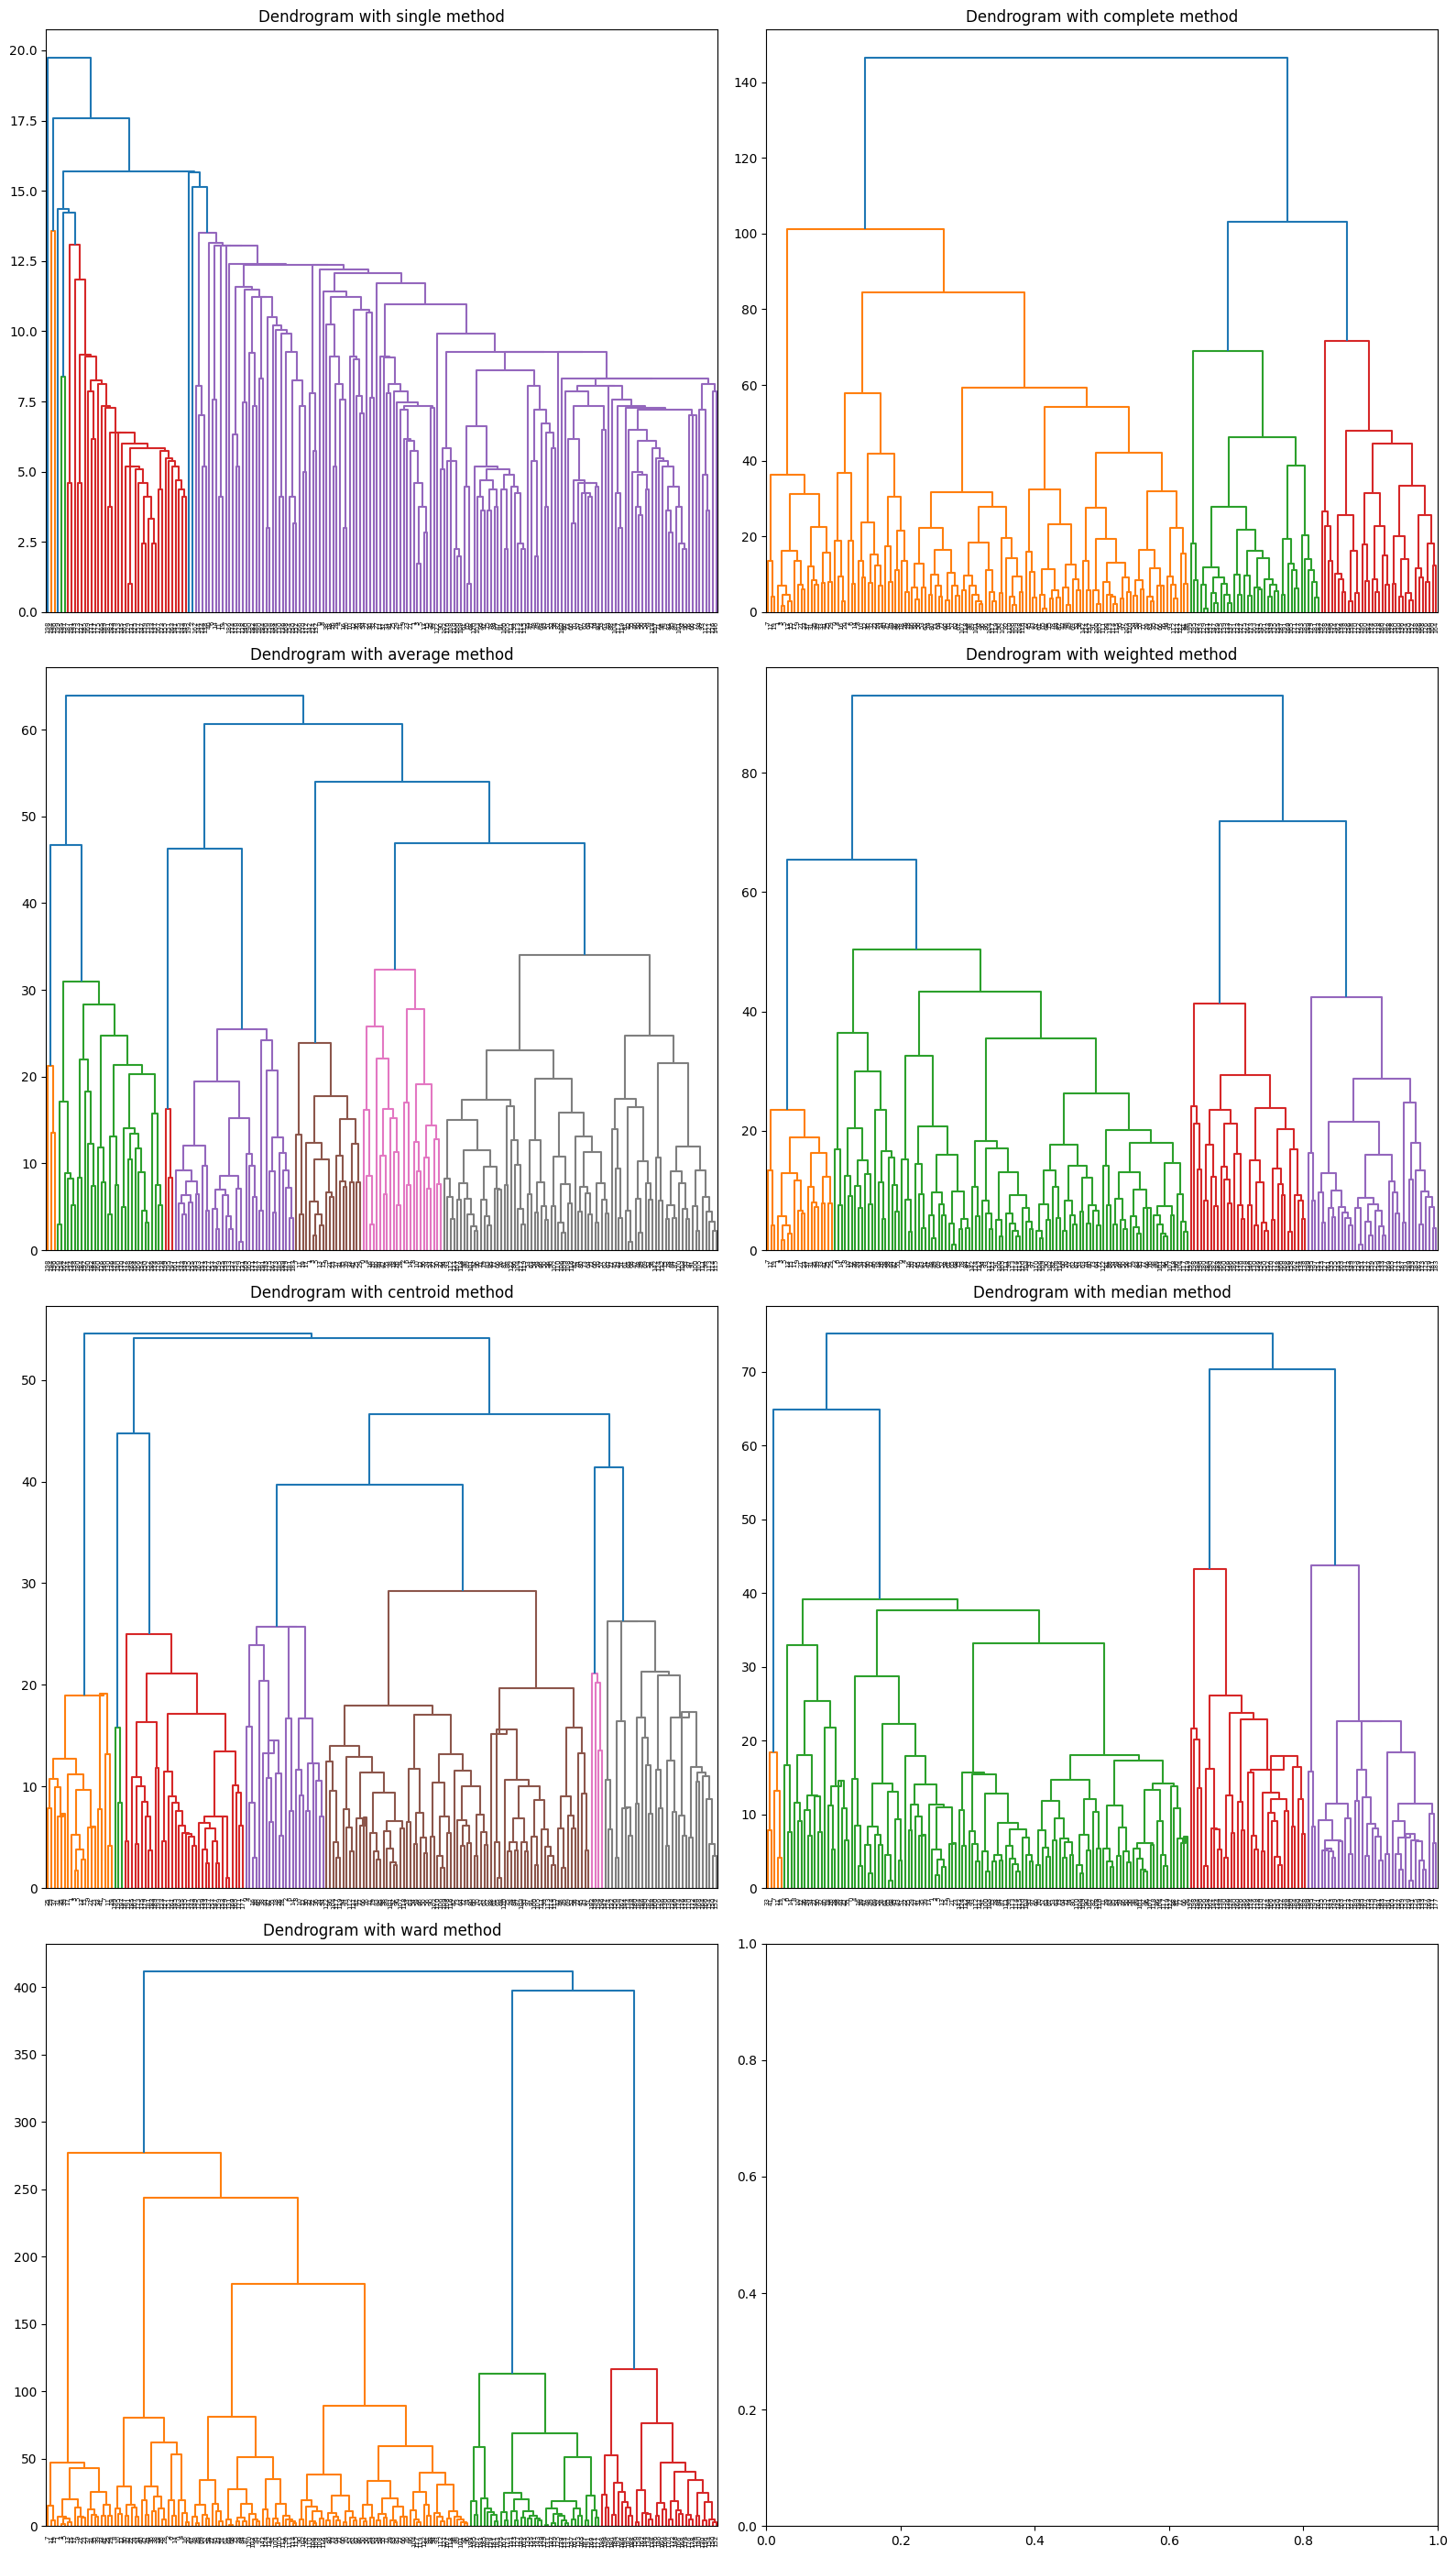

In [17]:
methods = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']
fig, axs = plt.subplots(4, 2, figsize=(16, 28))

dist = hierarchy.distance.pdist(X, 'euclidean')

for i, method in enumerate(methods):
    Z = hierarchy.linkage(dist, method=method)

    ax = axs[i//2, i%2]
    hierarchy.dendrogram(Z, ax=ax, orientation='top')
    ax.set_title(f'Dendrogram with {method} method')

plt.tight_layout()
plt.show()

**Висновки з завдання 12 (детальні)**

1 З графіків ми можемо винести що найкраще поділив дані метод - weighted. Він об'єднав усі дані у 5 кластерів. Тому надалі ми будемо використовувати їх для кластеризації

**Завдання 13** 

А тепер зробимо порівняльний аналіз отриманих результатів кластеризації розглянутими методами:  
* В фінальних візуалізаціях треба використовувати **однакову** (на вашу думку оптимальну) кількість кластерів!!!  

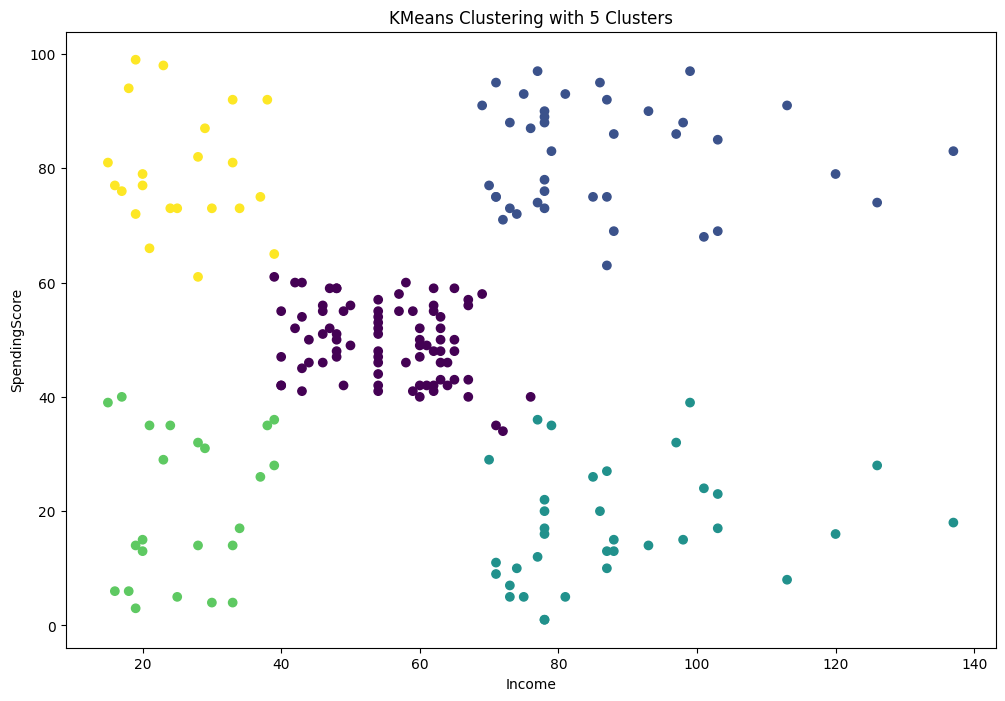

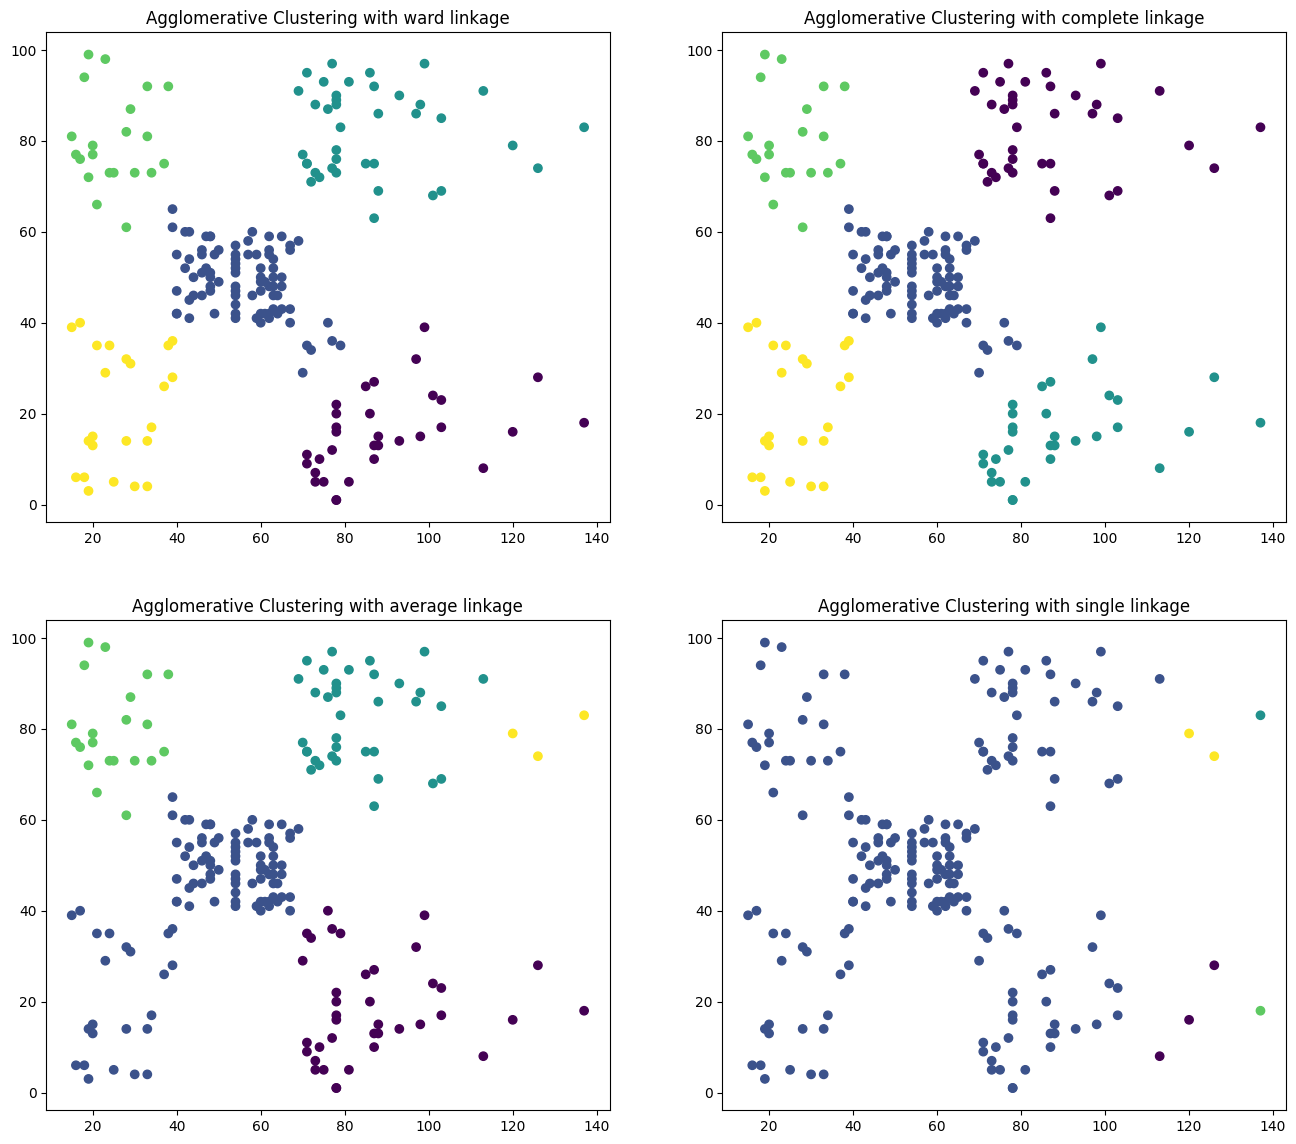

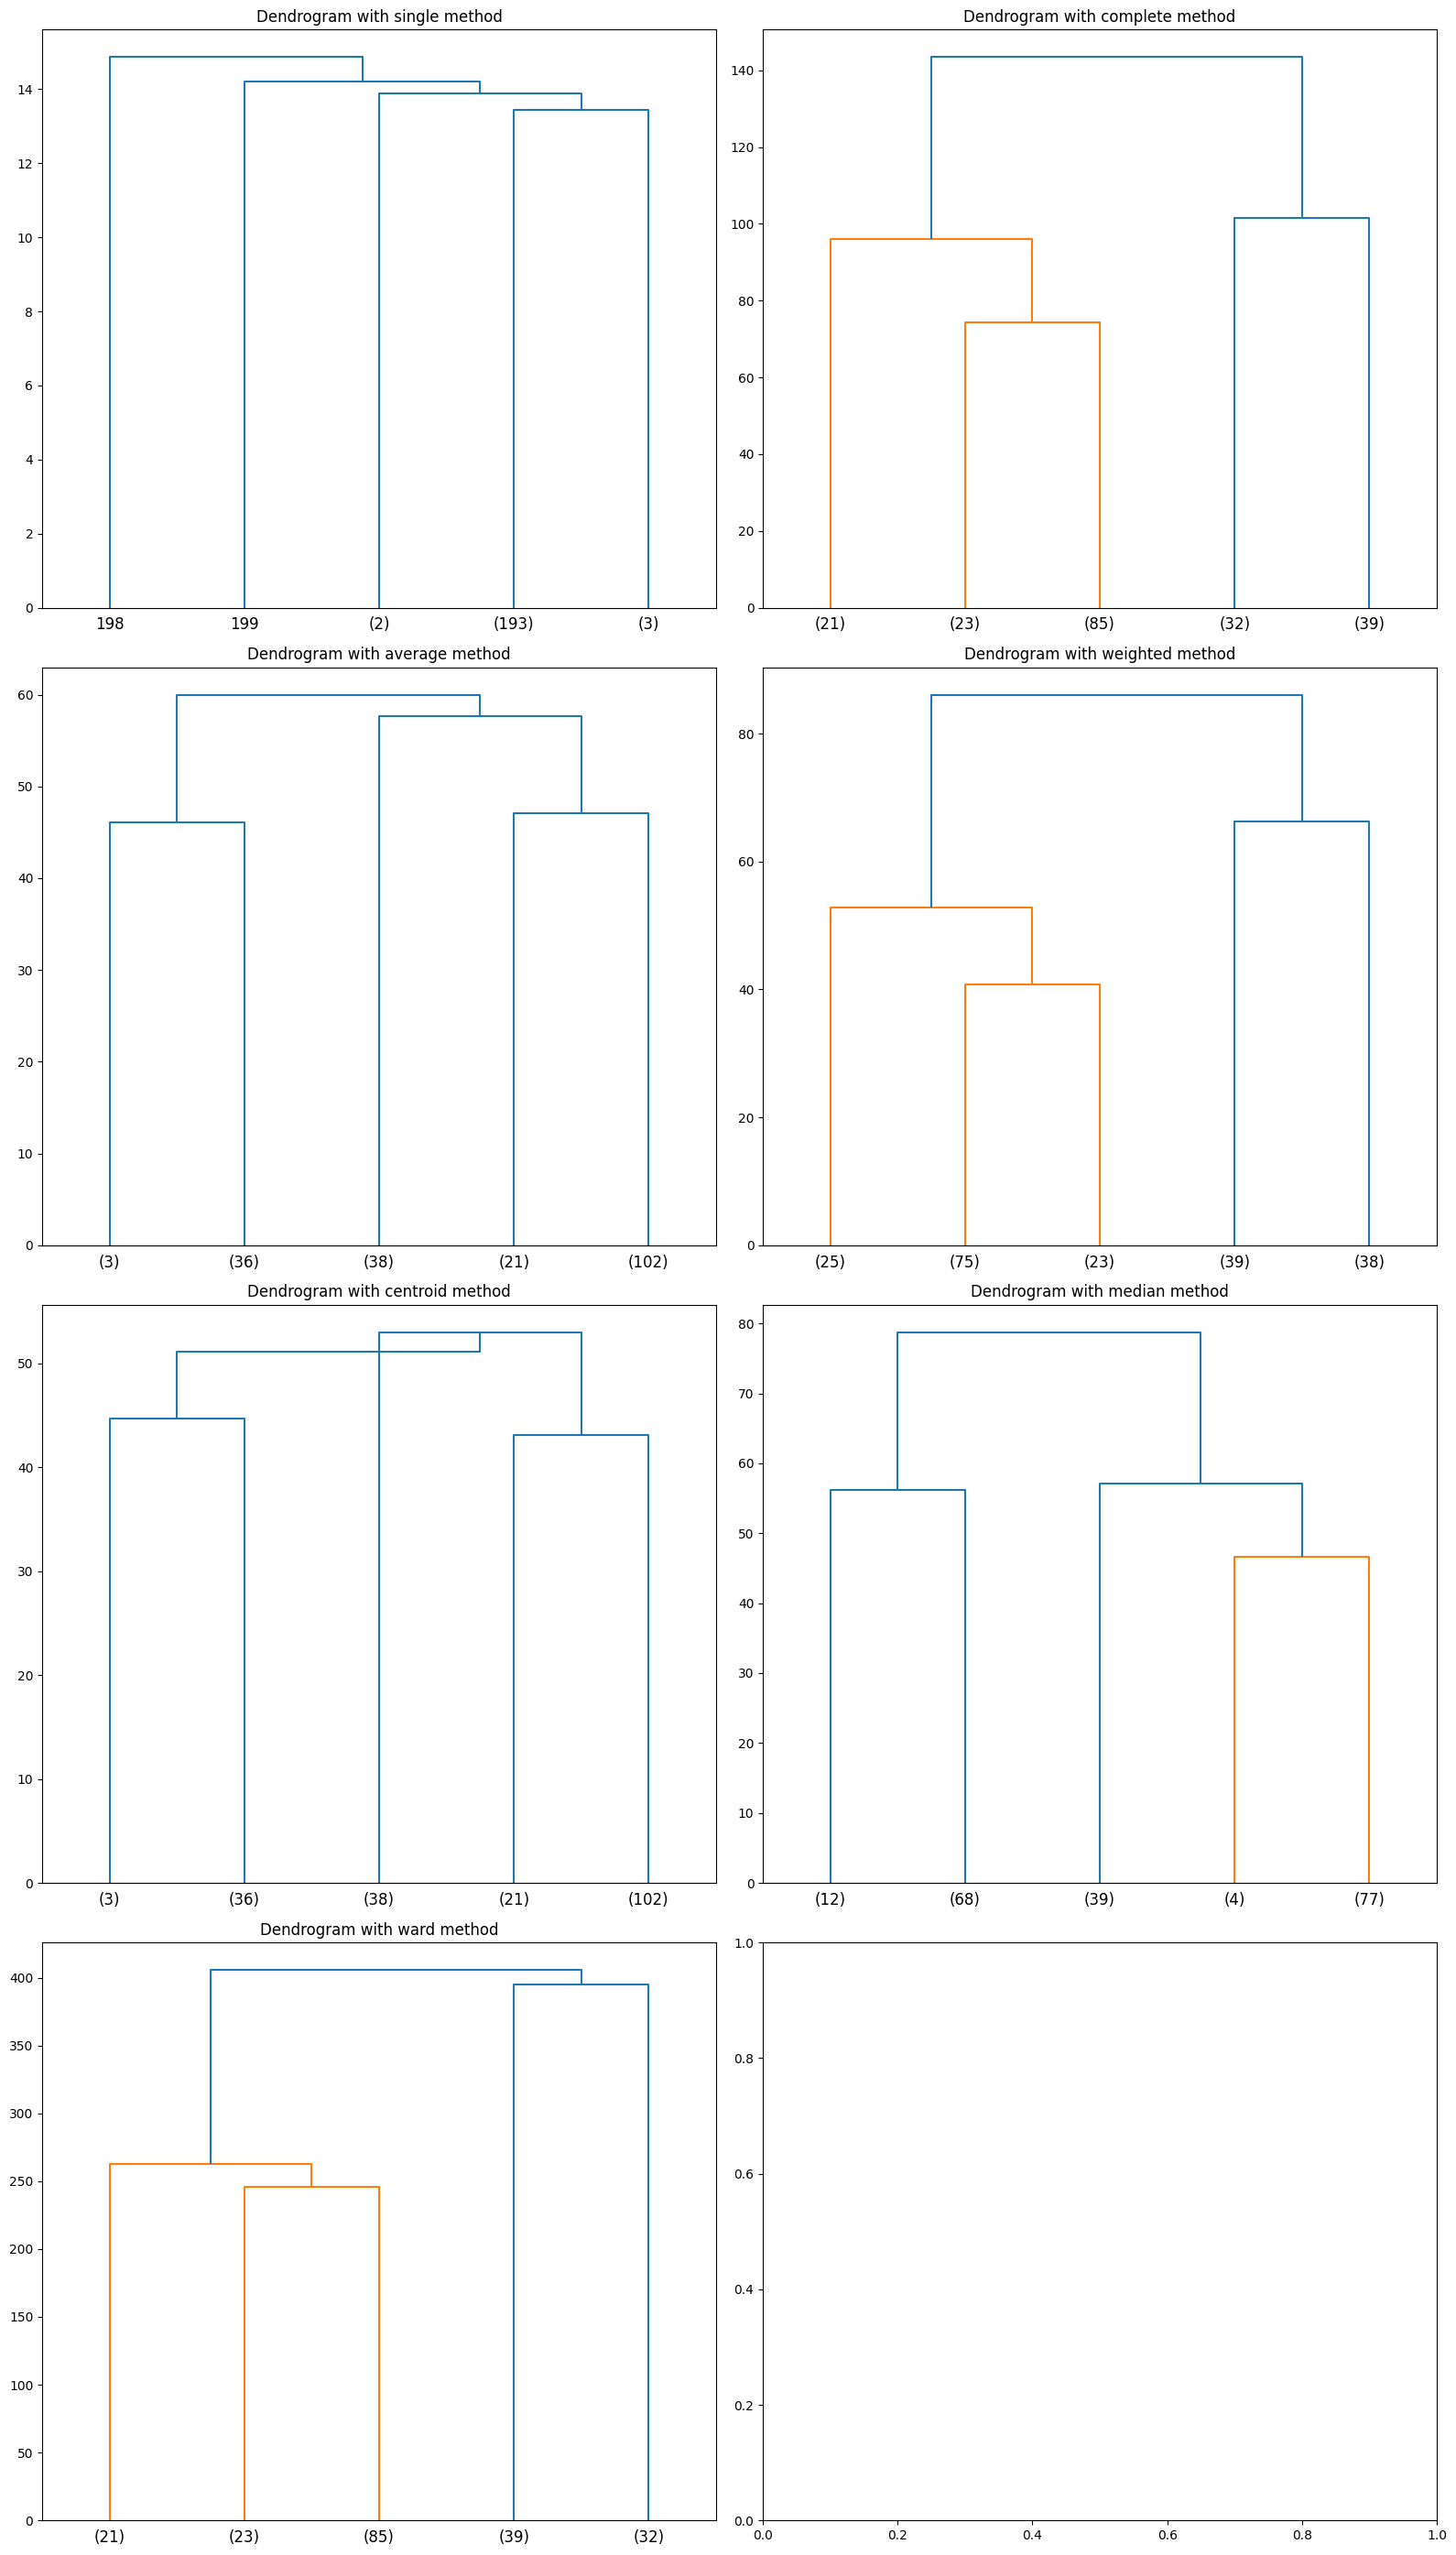

In [18]:
X = customer_set[['Income', 'SpendingScore']]

n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
plt.figure(figsize=(12, 8))
plt.scatter(X['Income'], X['SpendingScore'], c=kmeans.labels_, cmap='viridis')
plt.xlabel('Income')
plt.ylabel('SpendingScore')
plt.title('KMeans Clustering with 5 Clusters')
plt.show()



linkages = ['ward', 'complete', 'average', 'single']
fig, axs = plt.subplots(2, 2, figsize=(16, 14))

for i, linkage in enumerate(linkages):
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage).fit(X)

    ax = axs[i//2, i%2]
    ax.scatter(X['Income'], X['SpendingScore'], c=clustering.labels_, cmap='viridis')
    ax.set_title(f'Agglomerative Clustering with {linkage} linkage')

plt.show()


methods = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']
fig, axs = plt.subplots(4, 2, figsize=(16, 28))


dist = hierarchy.distance.pdist(X, 'euclidean')

for i, method in enumerate(methods):
    Z = hierarchy.linkage(dist, method=method)

    ax = axs[i//2, i%2]
    hierarchy.dendrogram(Z, ax=ax, truncate_mode='lastp', p=n_clusters)
    ax.set_title(f'Dendrogram with {method} method')


plt.tight_layout()
plt.show()

**Висновки з завдання 13 (детальні)**

1. Agglomerative Clustering: це такий метод, що кожен об'єкт спочатку у своєму власному кластері, а потім поступово об'єднує близькі за характеристиками об'єкти в один кластер. Процес продовжується, поки всі об'єкти не будуть об'єднані в один загальний кластер або досягне певної кількості кластерів. Метод single згрупував майже усі елементи в один кластер, тому він спрацював найгірше. Методи complete i ward спрацювали найкраще.

2. Dendrograms: чим ближче об'єкти на дендрограмі, тим більш схожі вони між собою і тим самим об'єднюються і утворюють дерево. Найкраще спрацював метод ward, так як ми можемо бачити досить рівномірний поділ данних, особливо якщо порівнювати з іншими методами, які в свою червгу спрацювали менш точно

3. KMeans Clustering: алгоритм спочатку випадковим чином вибирає центри кластерів, а потім по черзі кожен об'єкт призначається до найближчого за відстанню центру кластера. Після цього центри кластерів оновлюються, вони переміщуються в середнє положення всіх об'єктів, що належать до цього кластера. В нашому випадку цей метод розділив дані добре, на відповідно 5 кластерів.